In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
 97% 386M/398M [00:00<00:00, 466MB/s]
100% 398M/398M [00:00<00:00, 539MB/s]


In [ ]:
!unzip -q face-mask-detection.zip -d dataset

# 1. Install & Import Libraries

In [1]:
!pip install -q tensorflow opencv-python-headless

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 2. Set Paths & Label Encoder

In [3]:
IMG_SIZE = 160
IMAGE_PATH = '/content/dataset/images'
ANNOTATION_PATH = '/content/dataset/annotations'
labels = ["with_mask", "without_mask", "mask_weared_incorrect"]
le = LabelEncoder()
le.fit(labels)

LabelEncoder()

# 3. Parse Annotations

In [4]:
images, boxes, classes = [], [], []

In [5]:
def parse_voc_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    img_path = os.path.join(IMAGE_PATH, filename)
    img = cv2.imread(img_path)
    if img is None:
        return
    h, w = img.shape[:2]
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    for obj in root.findall('object'):
        label = obj.find('name').text
        box = obj.find('bndbox')
        xmin = int(box.find('xmin').text) / w
        ymin = int(box.find('ymin').text) / h
        xmax = int(box.find('xmax').text) / w
        ymax = int(box.find('ymax').text) / h

        images.append(img)
        boxes.append([xmin, ymin, xmax, ymax])
        classes.append(le.transform([label])[0])

for file in os.listdir(ANNOTATION_PATH):
    if file.endswith('.xml'):
        parse_voc_annotation(os.path.join(ANNOTATION_PATH, file))

X = np.array(images)
y_box = np.array(boxes)
y_class = tf.keras.utils.to_categorical(classes, num_classes=3)

4. Train/Validation/Test Split

In [6]:
X_train, X_temp, yb_train, yb_temp, yc_train, yc_temp = train_test_split(X, y_box, y_class, test_size=0.3, random_state=42)

In [7]:
# Step 1: Create index split
val_idx, test_idx = train_test_split(
    np.arange(len(X_temp)), test_size=0.5, random_state=42)

# Step 2: Slice the arrays based on indices
X_val, X_test = X_temp[val_idx], X_temp[test_idx]
yb_val, yb_test = yb_temp[val_idx], yb_temp[test_idx]
yc_val, yc_test = yc_temp[val_idx], yc_temp[test_idx]


# 5. Build CNN Model (MobileNetV2)

In [13]:
base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(160, 160, 3))
base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(128, activation='relu')(x)

In [15]:
bbox_head = layers.Dense(4, name='bbox_output')(x)
class_head = layers.Dense(3, activation='softmax', name='class_output')(x)

model = models.Model(inputs=base.input, outputs=[bbox_head, class_head])

# 6. IoU Metric

In [16]:
def iou_metric(y_true, y_pred):
    ymin_true, xmin_true, ymax_true, xmax_true = tf.split(y_true, 4, axis=-1)
    ymin_pred, xmin_pred, ymax_pred, xmax_pred = tf.split(y_pred, 4, axis=-1)

    inter_xmin = tf.maximum(xmin_true, xmin_pred)
    inter_ymin = tf.maximum(ymin_true, ymin_pred)
    inter_xmax = tf.minimum(xmax_true, xmax_pred)
    inter_ymax = tf.minimum(ymax_true, ymax_pred)

    inter_area = tf.maximum((inter_xmax - inter_xmin), 0) * tf.maximum((inter_ymax - inter_ymin), 0)
    true_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    pred_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    union_area = true_area + pred_area - inter_area
    return tf.reduce_mean(inter_area / (union_area + 1e-6))

7. Compile & Train Model

In [17]:
model.compile(optimizer='adam',
              loss={'bbox_output': 'mse', 'class_output': 'categorical_crossentropy'},
              metrics={'bbox_output': iou_metric, 'class_output': 'accuracy'})

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, {'bbox_output': yb_train, 'class_output': yc_train},
    validation_data=(X_val, {'bbox_output': yb_val, 'class_output': yc_val}),
    epochs=20, batch_size=16, callbacks=callbacks
)

Epoch 1/20
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - bbox_output_iou_metric: 0.0060 - bbox_output_loss: 0.3293 - class_output_accuracy: 0.7762 - class_output_loss: 0.6723 - loss: 1.0017

179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - bbox_output_iou_metric: 0.0060 - bbox_output_loss: 0.3274 - class_output_accuracy: 0.7764 - class_output_loss: 0.6715 - loss: 0.9989 - val_bbox_output_iou_metric: 0.0141 - val_bbox_output_loss: 0.0790 - val_class_output_accuracy: 0.8331 - val_class_output_loss: 0.4803 - val_loss: 0.5638
Epoch 2/20
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - bbox_output_iou_metric: 0.0135 - bbox_output_loss: 0.0766 - class_output_accuracy: 0.8300 - class_output_loss: 0.4781 - loss: 0.5547

179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - bbox_output_iou_metric: 0.0135 - bbox_output_loss: 0.0766 - class_output_accuracy: 0.8299 - class_output_loss: 0.4783 - loss: 0.5549 - val_bbox_output_iou_metric: 0.0110 - val_bbox_output_loss: 0.0809 - val_class_output_accuracy: 0.8462 - val_class_output_loss: 0.4442 - val_loss: 0.5303
Epoch 3/20
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - bbox_output_iou_metric: 0.0182 - bbox_output_loss: 0.0634 - class_output_accuracy: 0.8240 - class_output_loss: 0.4675 - loss: 0.5309

179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 207ms/step - bbox_output_iou_metric: 0.0182 - bbox_output_loss: 0.0634 - class_output_accuracy: 0.8240 - class_output_loss: 0.4674 - loss: 0.5308 - val_bbox_output_iou_metric: 0.0236 - val_bbox_output_loss: 0.0748 - val_class_output_accuracy: 0.8478 - val_class_output_loss: 0.4323 - val_loss: 0.5109
Epoch 4/20
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - bbox_output_iou_metric: 0.0207 - bbox_output_loss: 0.0618 - class_output_accuracy: 0.8431 - class_output_loss: 0.4273 - loss: 0.4892

179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 231ms/step - bbox_output_iou_metric: 0.0206 - bbox_output_loss: 0.0619 - class_output_accuracy: 0.8431 - class_output_loss: 0.4274 - loss: 0.4893 - val_bbox_output_iou_metric: 0.0131 - val_bbox_output_loss: 0.0685 - val_class_output_accuracy: 0.8396 - val_class_output_loss: 0.4359 - val_loss: 0.5099
Epoch 5/20
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - bbox_output_iou_metric: 0.0157 - bbox_output_loss: 0.0592 - class_output_accuracy: 0.8323 - class_output_loss: 0.4301 - loss: 0.4893

179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 239ms/step - bbox_output_iou_metric: 0.0158 - bbox_output_loss: 0.0592 - class_output_accuracy: 0.8324 - class_output_loss: 0.4299 - loss: 0.4891 - val_bbox_output_iou_metric: 0.0230 - val_bbox_output_loss: 0.0604 - val_class_output_accuracy: 0.8429 - val_class_output_loss: 0.4239 - val_loss: 0.4917
Epoch 6/20
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - bbox_output_iou_metric: 0.0209 - bbox_output_loss: 0.0523 - class_output_accuracy: 0.8622 - class_output_loss: 0.3708 - loss: 0.4231

179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 263ms/step - bbox_output_iou_metric: 0.0209 - bbox_output_loss: 0.0523 - class_output_accuracy: 0.8620 - class_output_loss: 0.3712 - loss: 0.4235 - val_bbox_output_iou_metric: 0.0199 - val_bbox_output_loss: 0.0611 - val_class_output_accuracy: 0.8445 - val_class_output_loss: 0.4221 - val_loss: 0.4890
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 261ms/step - bbox_output_iou_metric: 0.0254 - bbox_output_loss: 0.0539 - class_output_accuracy: 0.8553 - class_output_loss: 0.3635 - loss: 0.4174 - val_bbox_output_iou_metric: 0.0126 - val_bbox_output_loss: 0.0612 - val_class_output_accuracy: 0.8412 - val_class_output_loss: 0.4409 - val_loss: 0.5058
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 243ms/step - bbox_output_iou_metric: 0.0248 - bbox_output_loss: 0.0514 - class_output_accuracy: 0.8399 - class_output_loss: 0.3814 - loss: 0.4328 - val_bbox_output_iou_metric: 0.0196 - val_bbox_output_loss: 0.0607 - val_class_output_accuracy: 0.8396 - val_class_output_loss: 0.

# 8. Visualize Predictions

In [18]:
def draw(image, box, label):
    h, w = image.shape[:2]
    xmin, ymin, xmax, ymax = box
    xmin, xmax = int(xmin * w), int(xmax * w)
    ymin, ymax = int(ymin * h), int(ymax * h)
    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    image = cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    return image

In [19]:
def decode_label(one_hot):
    return le.classes_[np.argmax(one_hot)]

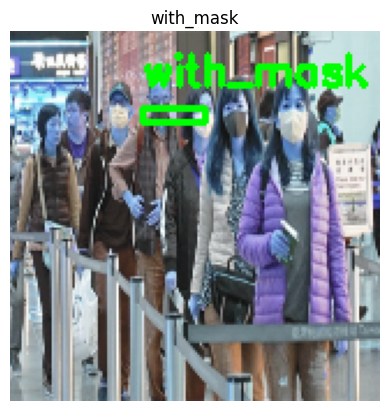

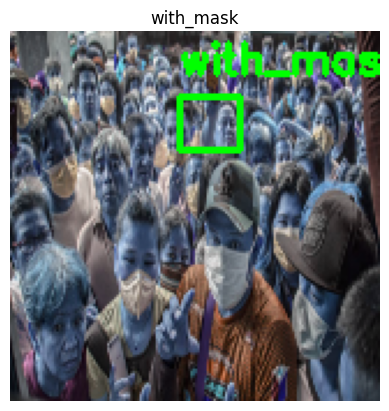

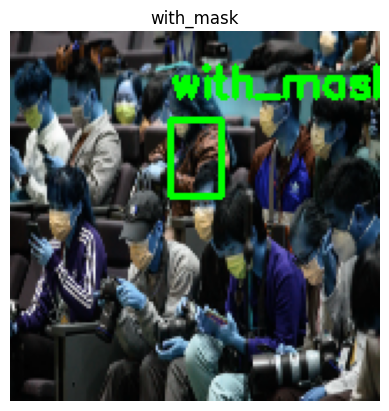

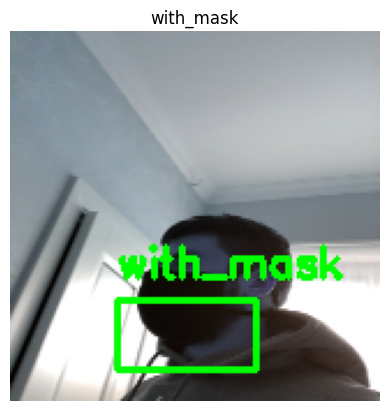

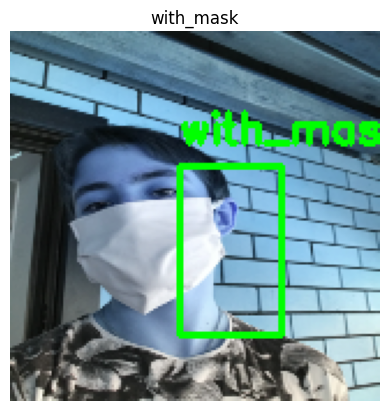

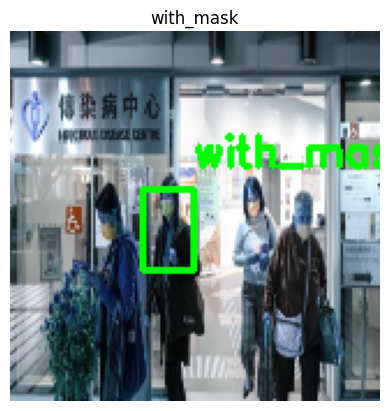

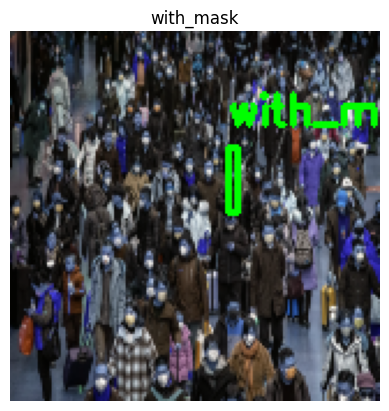

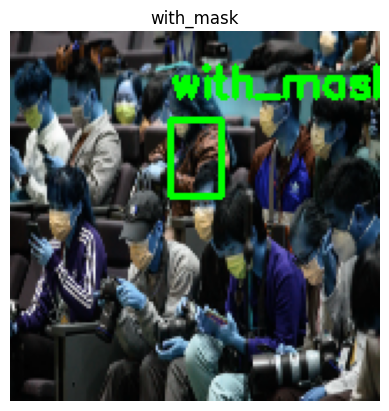

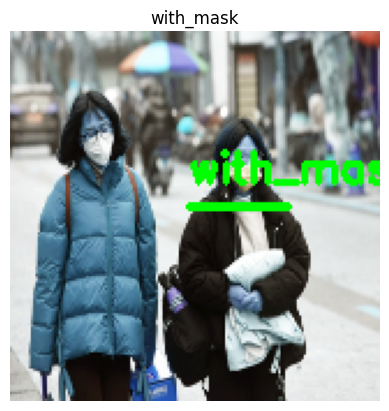

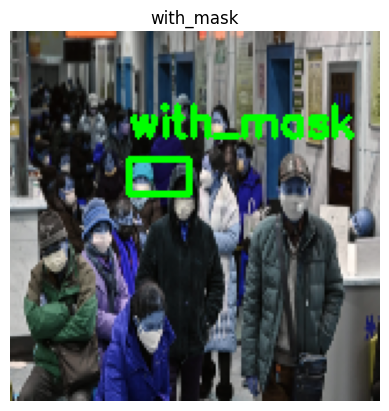

In [20]:
for i in range(10):
    idx = np.random.randint(0, len(X_test))
    image = X_test[idx]
    pred_box, pred_class = model.predict(np.expand_dims(image, axis=0), verbose=0)
    label = decode_label(pred_class[0])
    vis = draw((image * 255).astype(np.uint8), pred_box[0], label)
    plt.imshow(vis)
    plt.axis('off')
    plt.title(label)
    plt.show()

# 9. Export for Deployment

In [23]:
model.export('saved_model')

# Optional: Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Deployment model saved.")


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]
Captures:
  139062219571472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062219573008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062219573392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062219573200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062219571664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062219574544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062219574928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062219575312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062219575120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062219572432: Tens